## 04-Logistic regression

#### In this section we are going to compare the running speed of parallel and single-machine problems by applying logistic regression to cyber-security dataset--CIC-IDS2017.

In [89]:
## importing the required packages
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
## loading the dataset
spark = SparkSession.builder.appName('CICIDS2017').getOrCreate()
df = spark.read.csv('Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv', header = True, inferSchema = True)
df.printSchema()

## Converting to pandas
pd.DataFrame(df.take(5), columns=df.columns).transpose()


root
 |--  Destination Port: integer (nullable = true)
 |--  Flow Duration: integer (nullable = true)
 |--  Total Fwd Packets: integer (nullable = true)
 |--  Total Backward Packets: integer (nullable = true)
 |-- Total Length of Fwd Packets: integer (nullable = true)
 |--  Total Length of Bwd Packets: integer (nullable = true)
 |--  Fwd Packet Length Max: integer (nullable = true)
 |--  Fwd Packet Length Min: integer (nullable = true)
 |--  Fwd Packet Length Mean: double (nullable = true)
 |--  Fwd Packet Length Std: double (nullable = true)
 |-- Bwd Packet Length Max: integer (nullable = true)
 |--  Bwd Packet Length Min: integer (nullable = true)
 |--  Bwd Packet Length Mean: double (nullable = true)
 |--  Bwd Packet Length Std: double (nullable = true)
 |-- Flow Bytes/s: double (nullable = true)
 |--  Flow Packets/s: double (nullable = true)
 |--  Flow IAT Mean: double (nullable = true)
 |--  Flow IAT Std: double (nullable = true)
 |--  Flow IAT Max: integer (nullable = true)
 |-- 

,0,1,2,3,4
Destination Port,22,22,22,22,35396
Flow Duration,1266342,1319353,160,1303488,77
Total Fwd Packets,41,41,1,41,1
Total Backward Packets,44,44,1,42,2
Total Length of Fwd Packets,2664,2664,0,2728,0
...,...,...,...,...,...
Idle Mean,0,0,0,0,0
Idle Std,0,0,0,0,0
Idle Max,0,0,0,0,0
Idle Min,0,0,0,0,0


In [90]:
## Using the spark RDS describe
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Destination Port,286096,8015.814957217158,15346.254906099777,0,65389
Flow Duration,286096,5386306.348641715,2.1936997865904424E7,-13,119999949
Total Fwd Packets,286096,3.4763051563111684,19.527595617211375,1,3119
Total Backward Packets,286096,3.523953498126503,28.30708633934783,0,3635
Total Length of Fwd Packets,286096,233.70333035065153,1866.7146951985756,0,232349
Total Length of Bwd Packets,286096,2710.753970695151,51010.78140822222,0,7150819
Fwd Packet Length Max,286096,81.13227727755718,327.96891942409906,0,13929
Fwd Packet Length Min,286096,10.360361556959901,24.252210721834743,0,1472
Bwd Packet Length Max,286096,185.88710083328672,586.0631690985899,0,10136


In [91]:
## Preparing the data
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
stages = []
## Using the StringIndexer to encode our labels to label indices
label_stringIdx = StringIndexer(inputCol = " Label", outputCol = "label")
stages += [label_stringIdx]
## Using the VectorAssembler to combine all the feature columns into a single vector column
assemblerInputs = df.columns[0:78]
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [92]:
## Making a "data processing pipeline",in which we use Pipeline to chain multiple Transformers and Estimators together to specify our machine learning workflow. A Pipeline’s stages are specified as an ordered array.

from pyspark.ml import Pipeline
cols=df.columns
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |--  Destination Port: integer (nullable = true)
 |--  Flow Duration: integer (nullable = true)
 |--  Total Fwd Packets: integer (nullable = true)
 |--  Total Backward Packets: integer (nullable = true)
 |-- Total Length of Fwd Packets: integer (nullable = true)
 |--  Total Length of Bwd Packets: integer (nullable = true)
 |--  Fwd Packet Length Max: integer (nullable = true)
 |--  Fwd Packet Length Min: integer (nullable = true)
 |--  Fwd Packet Length Mean: double (nullable = true)
 |--  Fwd Packet Length Std: double (nullable = true)
 |-- Bwd Packet Length Max: integer (nullable = true)
 |--  Bwd Packet Length Min: integer (nullable = true)
 |--  Bwd Packet Length Mean: double (nullable = true)
 |--  Bwd Packet Length Std: double (nullable = true)
 |-- Flow Bytes/s: double (nullable = true)
 |--  Flow Packets/s: double (nullable = true)
 |--  Flow IAT Mean: double (nullable = true)
 |--  Flow IAT Std

In [93]:
## Randomly split data into train and test sets, and set seed for reproducibility
train, test = df.randomSplit([0.7, 0.3], seed = 888)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 200072
Test Dataset Count: 86024


In [119]:
## Fit a logistic regression
import time
import pickle
from pyspark.ml.classification import LogisticRegression
start=time.time() ## recording the time spent
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=100)
lrModel = lr.fit(train)
predictions = lrModel.transform(test)
end=time.time()
running_time=end-start
print('time cost : %.5f sec' %running_time)
pickle.dump(running_time, open( "time_parallel.p", "wb" ) )  ## exporting and saving the time spent

time cost : 54.45072 sec


#### And we can obtain the coefficients below

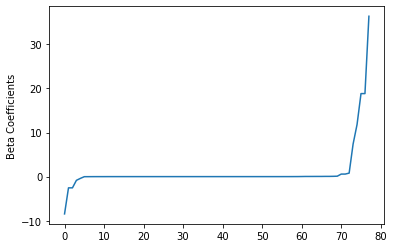

In [115]:
## Plot the results
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.savefig('output/bank_betas.png')
plt.show()
plt.close()

#### Summarize the model over the training set

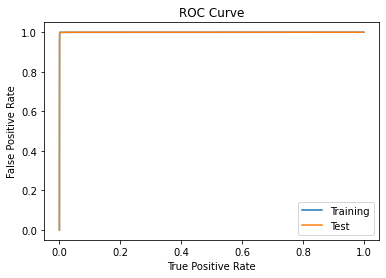

Training set areaUnderROC: 0.9998991716619078


In [116]:
## ROC curves

trainingSummary = lrModel.summary

predpandas=predictions.select(['label','probability']).toPandas()
predpandas['probability']=[x[1] for x in predpandas['probability']]
from sklearn.metrics import roc_curve
testrocarray = roc_curve(predpandas['label'], predpandas['probability'])
testroc = pd.DataFrame.from_records(testrocarray).transpose()
testroc.columns=['FPR','TPR','Thresh']

trainroc = trainingSummary.roc.toPandas()

plt.plot(trainroc['FPR'],trainroc['TPR'],label='Training')
plt.plot(testroc['FPR'],testroc['TPR'],label='Test')
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.savefig('output/banks_roc.png')
plt.show()
plt.close()

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))


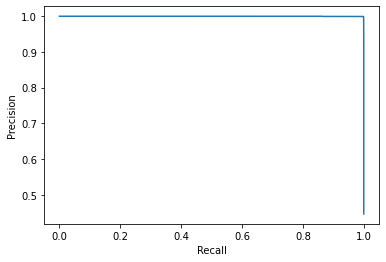

In [117]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

#### As showed by the plots above, this model has a good performance

#### Then we work in the single-machine problem, calculate the time spent, and compare it with the time spent by the parallel algorithm.

In [99]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
df2=pd.read_csv("Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv")  ## reloading the dataset in another way
cleanup = {' Label':{'BENIGN':0, 'PortScan':1}}
df2.replace(cleanup, inplace=True)
array = df2.values
x = array[:,0:78]
y = array[:,78]
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3, random_state=1)

In [121]:
from sklearn.linear_model import SGDClassifier
start=time.time()
clf_log = SGDClassifier(loss='log',n_jobs=-1,alpha=0.01)
clf_log.fit(train_x, train_y)
pre_log = clf_log.predict(test_x)
end=time.time()
running_time=end-start
print('time cost : %.5f sec' %running_time)
pickle.dump(running_time, open( "time_single.p", "wb" ) ) ## collecting the time spent to do comparison

time cost : 7.24562 sec


#### As a result, we can see that the outcomes are not ideal and just the opposite of what was expected, of which the parallel algorithm should have spend less time on logistic regression. This might because of the limitation of the dataset's size,or might because of the parameter tuning is not perfect, it isn't complex enough so that the advantage of the parallel algorithm have not been reflected. 

#### Reference:
    A binary classification problem with pyspark and MLlib[https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa]
    Way of calculate the running time[https://blog.csdn.net/Mr_Cat123/article/details/80681061]
    Logistic regression in Python[https://realpython.com/logistic-regression-python/#logistic-regression-python-packages]
    Workshop[https://dsbristol.github.io/dst/coursebook/11.html]